In [1]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import json
import matplotlib.pyplot as plt
#!pip install tqdm
from tqdm import tqdm_notebook as tqdm #if running in a notebook
#from tqdm import tqdm as tqdm #if not running in a notebook
from scipy.stats.stats import pearsonr
#from numpy import correlate as corr #not pearson 

# Made by:
# Name			Studentnumber
# Niels van den Hork s4572602
# Niels van Drueten	s4496604

In [2]:
# Boolean to load correlation from file.
get_correlation_from_file = False

# Filename to store/load correlation matrix.
filename = "correlations.json"


# PRESENT Cipher SBox
SBox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]


In [3]:
# Function f is the intermediate result,
# where _in is the known non-constant data value
# and k is a small part of the key.
def f(i, k):
	return SBox[i ^ k]

# Returns the Hamming Weight of val.
def hw(val):
	return bin(val).count("1")


In [4]:
# Returns a Value-Prediction Matrix of size [no_inputs x no_keys]
# Input _in: Input matrix variable of size [no_inputs]
def construct_val_pred_matrix(_in, key_len):
	output = np.zeros((len(_in), 2**key_len), dtype="uint8")
	for i in range(len(_in)):
		in_elem = _in[i][0]
		for k in range(2**key_len):
			val = f(in_elem,k)
			output[i][k] = val
	return output	

# Returns a Power-Prediction Matrix of size [no_inputs x no_keys]
# Input _in: Value-Prediction Matrix of size [no_inputs x no_keys]
def construct_pow_pred_matrix(val_pred_matrix, key_len):
	output = np.zeros((len(_in), 2**key_len), dtype="uint8")
	for i in range(len(_in)):
		in_elem = _in[i][0]
		for k in range(2**key_len):
			val = val_pred_matrix[i][k]
			output[i][k] = hw(val)
	return output

In [5]:
# Uses the correlate function of the scipy io library,
# that cross-correlates two matrices.

def correlate_m(matrix1, matrix2):
    print(matrix1.shape,matrix2.shape)
   
    cols_matrix1 = matrix1.shape[1]
    cols_matrix2 = matrix2.shape[1]
    
    result = np.zeros((cols_matrix1,cols_matrix2))
    
    for i in tqdm(range(cols_matrix1)):
        for j in range(cols_matrix2):
            #result[i][j] = pearsonr(matrix1[:,i], matrix2[:,j])[0]
            result[i][j] = np.corrcoef(matrix1[:,i], matrix2[:,j])[0][1]
    return result


In [6]:
# Storing the correlation matrix in json.
def store_matrix(matrix):
	#matrix_list = matrix.tolist()
	json_string = ""
	for element in matrix:
		json_string += json.dumps(element.tolist())
	print(json_string)
	with open(filename, 'w') as outfile:
		json.dump(json_string, outfile)
	print("Correlation matrix stored in: {}".format(filename))


def load_matrix():
	return []

def sort_correlation(correlation):
	return list(sorted(correlation,key= lambda x: x[0][0]))


Input: 
 [[0]
 [8]
 [9]
 ...
 [2]
 [2]
 [4]] (14900, 1)


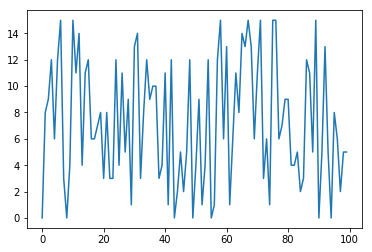

In [7]:
# Opens "in.mat" file.
in_file = loadmat('in.mat')
_in = in_file['in'] #contains 14900 4bit inputs

print(f"Input: \n {_in} {_in.shape}")

temp = [i[0] for i in _in]
plt.plot(temp[:100])
temp = None

Value prediction matrix: 
 [[12  5  6 ...  7  1  2]
 [ 3 14 15 ...  0 10 13]
 [14  3  8 ...  9 13 10]
 ...
 [ 6 11 12 ...  2  4  7]
 [ 6 11 12 ...  2  4  7]
 [ 9  0 10 ... 14 15  8]] (14900, 16)
Power prediction matrix: 
 [[2 2 2 ... 3 1 1]
 [2 3 4 ... 0 2 3]
 [3 2 1 ... 2 3 2]
 ...
 [2 3 2 ... 1 1 3]
 [2 3 2 ... 1 1 3]
 [2 0 2 ... 3 4 1]] (14900, 16)


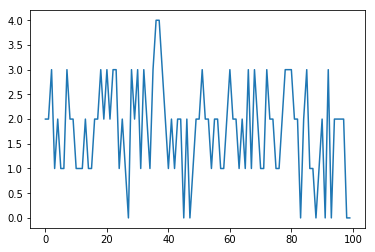

In [8]:
# Computing value prediction matrix
val_pred_matrix = construct_val_pred_matrix(_in, 4)
print(f"Value prediction matrix: \n {val_pred_matrix} {val_pred_matrix.shape}")


# Computing power prediction matrix
pow_pred_matrix = construct_pow_pred_matrix(val_pred_matrix, 4)
print(f"Power prediction matrix: \n {pow_pred_matrix} {pow_pred_matrix.shape}")

plt.plot(pow_pred_matrix[:100,0]) #first 100 input power for the first key (0)

Traces matrix: 
 [[-15.       -22.         3.       ...   1.         9.       -26.      ]
 [ -2.        -2.         1.       ...  -1.        -1.       -22.      ]
 [  0.         0.         0.       ...  18.        25.       -26.      ]
 ...
 [  2.5      -17.         9.       ...  -2.8       -5.        -4.      ]
 [ 18.        18.        18.       ...   2.5        3.5      -23.      ]
 [ -3.       -28.666666 -14.5      ...  17.        17.       -23.      ]] (14900, 6990)


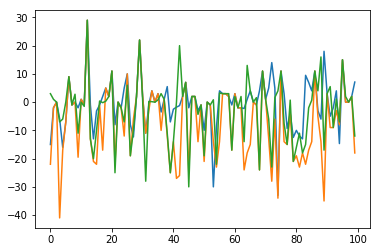

In [9]:
# Opens "traces.mat" file.
trace_file = loadmat('traces.mat')
_traces = trace_file['traces']
print(f"Traces matrix: \n {_traces} {_traces.shape}")

plt.plot(_traces[:100,0])
plt.plot(_traces[:100,1])
plt.plot(_traces[:100,2])

In [10]:
result = correlate_m(pow_pred_matrix, _traces)
print(result.shape)

(14900, 16) (14900, 6990)



(16, 6990)


Text(0, 0.5, 'summed absolute correlation')

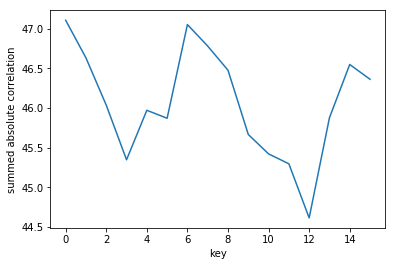

In [11]:
plt.plot([sum(list(map(abs,row))) for row in result])
plt.xlabel('key')
plt.ylabel('summed absolute correlation')

[6.00000000e+00 3.96100000e+03 4.26185631e-02]
[1.30000000e+01 6.44300000e+03 3.65798182e-02]
[0.00000000e+00 3.95800000e+03 3.60913569e-02]
[5.00000000e+00 6.81800000e+03 3.55024884e-02]
[1.20000000e+01 5.89400000e+03 3.54441996e-02]
[1.00000000e+01 5.89400000e+03 3.33130822e-02]
[4.0000000e+00 4.8280000e+03 3.2835813e-02]
[8.00000000e+00 3.90800000e+03 3.23732428e-02]
[3.00000000e+00 4.08200000e+03 3.22454278e-02]
[7.00000000e+00 4.53100000e+03 3.11703704e-02]
[1.40000000e+01 3.96100000e+03 3.10008286e-02]
[1.50000000e+01 6.78100000e+03 3.04143962e-02]
[9.0000000e+00 3.9610000e+03 3.0142407e-02]
[1.00000000e+00 6.63400000e+03 2.99411393e-02]
[1.10000000e+01 3.60000000e+01 2.92349193e-02]
[2.00000000e+00 5.32200000e+03 2.91781111e-02]


Text(0, 0.5, 'peak absolute correlation')

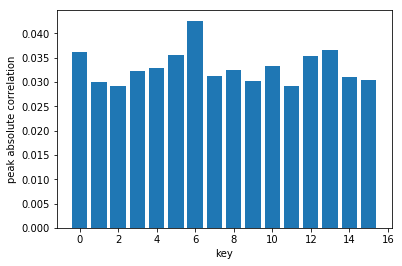

In [12]:
absresult = np.array([list(map(abs,row)) for row in result])
maxidx = np.argmax(absresult,axis=1)

maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )

[print(e) for e in smaxconf]
    
plt.bar(range(16),maxconf[:,2] )
plt.xlabel('key')
plt.ylabel('peak absolute correlation')

Text(0, 0.5, 'absolute correlation')

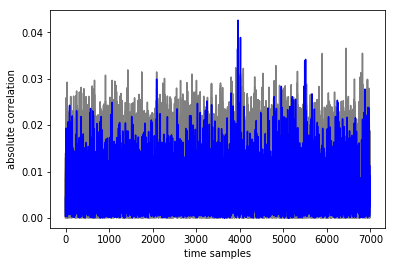

In [13]:
for i,row in enumerate(result):
    if i == 6:
        continue
    plt.plot(list(map(abs,row)),color='gray')
    
plt.plot(list(map(abs,result[6])),color='blue')
plt.xlabel('time samples')
plt.ylabel('absolute correlation')

In [14]:
keyranking = []
for amount in [500,1000,2000,4000,8000,12000]:
    result = correlate_m(pow_pred_matrix, _traces[:,:amount])
    
    absresult = np.array([list(map(abs,row)) for row in result])
    maxidx = np.argmax(absresult,axis=1)

    maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
    smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )
    #[print(e) for e in smaxconf]
    
    keyrank = np.array([e[0] for e in smaxconf])
    keyidx = np.where(keyrank == 6)[0][0]
    print(keyidx)
    keyranking.append(keyidx)



(14900, 16) (14900, 500)



10
(14900, 16) (14900, 1000)



14
(14900, 16) (14900, 2000)



15
(14900, 16) (14900, 4000)



0
(14900, 16) (14900, 6990)



0
(14900, 16) (14900, 6990)



0


Text(0, 0.5, 'ranking (lower is better)')

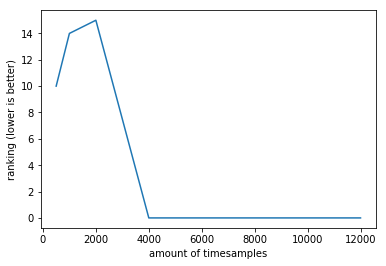

In [15]:
plt.plot(np.array([500,1000,2000,4000,8000,12000]),keyranking)   
plt.xlabel('amount of timesamples')
plt.ylabel('ranking (lower is better)')